Before you turn this lab in, make sure everything runs as expected. **Restart and run all cells** (in the menubar, select Kernel$\rightarrow$Restart & Run All) then check the output is as expected and there are no errors.  Also remember to **Save** before uploading this file (File$\rightarrow$Save and Checkpoint).

---

# <div align="center">Quantum Computer Systems Design</div>&nbsp;  <div align="center">Lab 5</div>

In the videos, you saw the steps to compile and optimize a quantum algorithm.  For this lab, you will again start with a small circuit, the Cuccaro adder.  This by itself is not a quantum algorithm but can be used as a component in algorithms.  The Cuccaro adder takes as input two quantum registers, a carry-in qubit, and a carry-out qubit and as output overwrites one of the registers and the carry-out bit with the sum.  In the previous lab you decomposed adder circuits.  In this lab you will optimize these decomposed circuits to find equivalent circuits with fewer gates.


# 0.1. Cuccaro Adder Definition

Below is the definition of the Cuccaro adder within Qiskit.  Run each of the below cells untill you reach question 1.1 to start.

In [1]:
import numpy as np
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.circuit.quantumregister import Qubit
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity, random_unitary
from qiskit.quantum_info.operators.predicates import matrix_equal
from qiskit import BasicAer
backend = BasicAer.get_backend('qasm_simulator')
from IPython.display import display

MAJ:


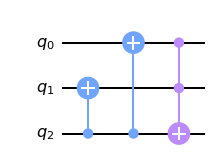

UMA2:


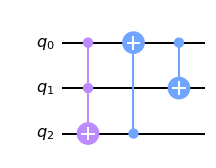

UMA3:


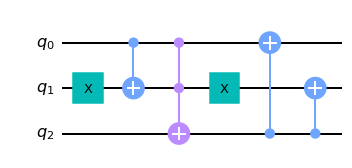

Cuccaro Adder:


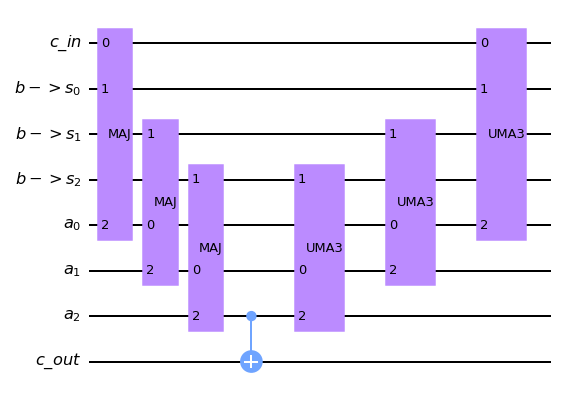

In [2]:
# Implementation of the Cuccaro Quantum Adder from
#   https://github.com/jmbaker94/quantumcircuitbenchmarks
# Design from the paper
#   https://arxiv.org/abs/quant-ph/0410184

# Majority gate
maj_c = QuantumCircuit(3, name='MAJ')
maj_c.cx(2, 1)
maj_c.cx(2, 0)
maj_c.ccx(0, 1, 2)
maj = maj_c.to_gate(label='MAJ')
print('MAJ:')
display(maj_c.draw(fold=-1))

# 2-CNOT version of UnMajority and Add gate
uma2_c = QuantumCircuit(3, name='UMA2')
uma2_c.toffoli(0, 1, 2)
uma2_c.cx(2, 0)
uma2_c.cx(0, 1)
uma2 = uma2_c.to_gate(label='UMA2')
print('UMA2:')
display(uma2_c.draw(fold=-1))

# 3-CNOT version of UnMajority and Add gate
# (Allows more parallelism in the circuit)
uma3_c = QuantumCircuit(3, name='UMA3')
uma3_c.x(1)
uma3_c.cx(0, 1)
uma3_c.toffoli(0, 1, 2)
uma3_c.x(1)
uma3_c.cx(2, 0)
uma3_c.cx(2, 1)
uma3 = uma3_c.to_gate(label='UMA3')
print('UMA3:')
display(uma3_c.draw(fold=-1))

def cuccaro_adder(c, cin, a, b, cout, uma=uma3):
    c.append(maj, [cin, b[0], a[0]])
    for i in range(1, len(b)):
        c.append(maj, [a[i-1], b[i], a[i]])

    c.cx(a[-1], cout)

    for i in reversed(range(1, len(b))):
        c.append(uma, [a[i-1], b[i], a[i]])
    c.append(uma, [cin, b[0], a[0]])

def generate_adder_circuit(n, uma=uma3):
    if n % 2 != 0:
        raise ValueError('Odd number of qubits')

    cin = QuantumRegister(1, 'c_in')
    a = QuantumRegister(n//2-1, 'a')
    b = QuantumRegister(n//2-1, 'b->s')
    cout = QuantumRegister(1, 'c_out')
    c = QuantumCircuit(cin, b, a, cout)
        
    cuccaro_adder(c, cin, a, b, cout, uma=uma)
    return c

print('Cuccaro Adder:')
cuccaro8 = generate_adder_circuit(8)
cuccaro8.draw(fold=-1)

In [3]:
def count_cnots(circuit, ignore_toffoli=False):
    '''A helper function that may or may not be useful.'''
    cnot_count = 0
    for [gate, qubits, cbits] in circuit:
        if len(qubits) <= 1 or (ignore_toffoli and len(qubits) == 3):
            pass
        elif len(qubits) == 2:
            cnot_count += 1
        else:
            raise ValueError('The circuit contains large gates that have not been decomposed')
    return cnot_count

In [4]:
# Export to QASM
print(cuccaro8.qasm())

OPENQASM 2.0;
include "qelib1.inc";
gate gate_MAJ q0,q1,q2 { cx q2,q1; cx q2,q0; ccx q0,q1,q2; }
gate gate_UMA3 q0,q1,q2 { x q1; cx q0,q1; ccx q0,q1,q2; x q1; cx q2,q0; cx q2,q1; }
qreg c_in[1];
qreg b->s[3];
qreg a[3];
qreg c_out[1];
gate_MAJ c_in[0],b->s[0],a[0];
gate_MAJ a[0],b->s[1],a[1];
gate_MAJ a[1],b->s[2],a[2];
cx a[2],c_out[0];
gate_UMA3 a[1],b->s[2],a[2];
gate_UMA3 a[0],b->s[1],a[1];
gate_UMA3 c_in[0],b->s[0],a[0];



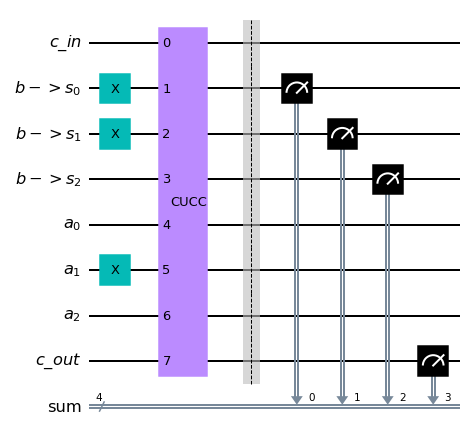

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


{'0101': 128}

In [5]:
# Try it out!
n = 8
cin = QuantumRegister(1, 'c_in')
a = QuantumRegister(n//2-1, 'a')
b = QuantumRegister(n//2-1, 'b->s')
cout = QuantumRegister(1, 'c_out')
creg = ClassicalRegister(n//2, 'sum')
c = QuantumCircuit(cin, b, a, cout, creg)

# Test on a specific input
# carry-in=0 CHANGE ME!
###c.x(cin[0])

# a=2 (0b010) CHANGE ME!
###c.x(a[0])
c.x(a[1])
###c.x(a[2])

# b=3 (0b011) CHANGE ME!
c.x(b[0])
c.x(b[1])
###c.x(b[2])

#cuccaro_adder(c, cin, a, b, cout)
c.append(cuccaro8.to_gate(label='CUCC'), [*cin, *b, *a, *cout])

# Measure the result
c.barrier()
c.measure([*b, *cout], creg)

# Show the circuit
display(c.draw(fold=-1))

# Simulate the result
# 0 + 2 + 3 = 5 (0b0101)
execute(c, backend, shots=128).result().get_counts(c)

# 1. Local Circuit Optimizations

Now that you have decomposed the circuit into one- and two-qubit gates, you will look at optimizing the circuit at the one- and two-qubit gate level.  To keep things simple, you will only optimize the 8-qubit Cuccaro adder shown below.

The fully decomposed Cuccaro adder (Qiskit default decomposition):


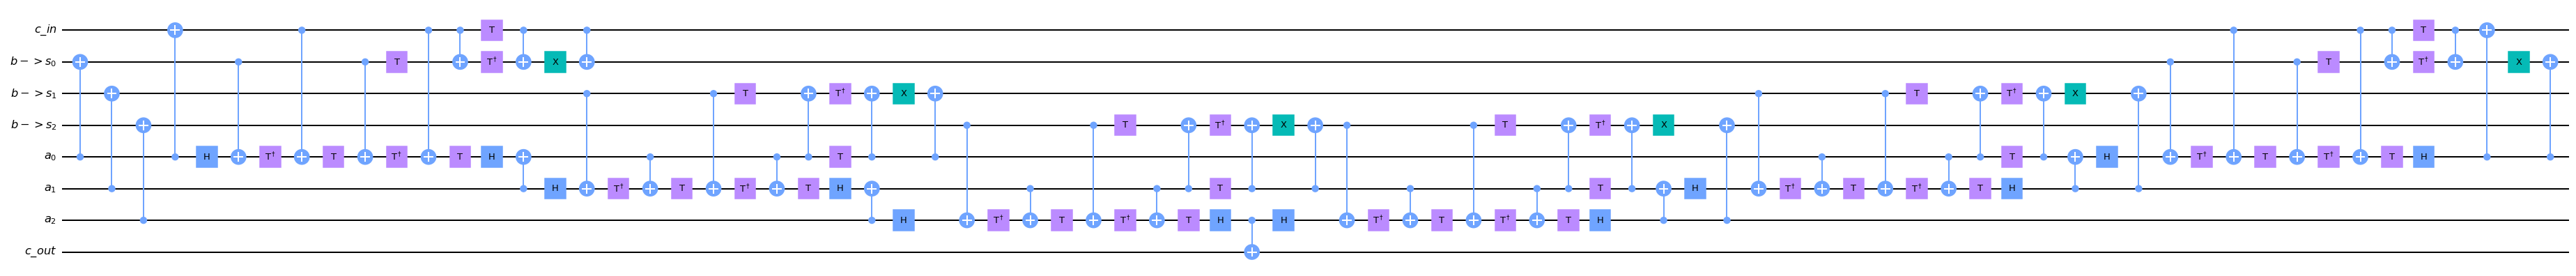

In [6]:
cuccaro8 = generate_adder_circuit(8)

print('The fully decomposed Cuccaro adder (Qiskit default decomposition):')
cucc_decomp = qiskit.transpile(cuccaro8, basis_gates=['x', 'h', 't', 'tdg', 'cx'])
cucc_decomp.draw(fold=-1)

## 1.1. Gate Commutation

Take a look at the decomposed Cuccaro adder above.  In this circuit of CNOT and single-qubit gates, there are several places where we can rearrange and cancel gates.  For this question, take this small piece of the circuit shown below.

Commute (i.e. move) the single-qubit gates as far right as possible in the circuit without changing the functionality.

A small piece of the decomposed Cuccaro adder:


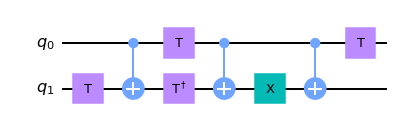

In [7]:
print('A small piece of the decomposed Cuccaro adder:')
subcirc = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[2];\nt q[1];\ncx q[0],q[1];\nt q[0];\ntdg q[1];\ncx q[0],q[1];\nx q[1];\ncx q[0],q[1];\nt q[0];\n')
subcirc.draw(fold=-1)

Your solution:
'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[2];\nt q[1];\ncx q[0],q[1];\ntdg q[1];\ncx q[0],q[1];\ncx q[0],q[1];\nx q[1];\nt q[0];\nt q[0];\n'


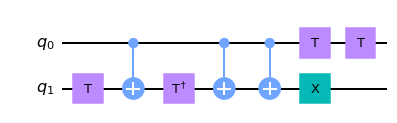

In [8]:
optimized_1 = QuantumCircuit(2)

# Rearrange these gates for your solution
# Do not add or remove gates
# You should get a circuit with two CNOTs next to each other
# and two T gates next to each other
# optimized_1.t(1)
# optimized_1.cx(0, 1)
# optimized_1.t(0)
# optimized_1.tdg(1)
# optimized_1.cx(0, 1)
# optimized_1.x(1)
# optimized_1.cx(0, 1)
# optimized_1.t(0)
# YOUR CODE HERE

optimized_1.t(1)
optimized_1.cx(0, 1)
optimized_1.tdg(1)
optimized_1.cx(0, 1)
optimized_1.cx(0, 1)
optimized_1.x(1)
optimized_1.t(0)
optimized_1.t(0)

print('Your solution:')
print(repr(optimized_1.qasm()))
optimized_1.draw(fold=-1)

In [9]:
# Do not delete this cell
# The autograder will test the value stored in `optimized_1`.
from collections import Counter
assert len(optimized_1) == len(subcirc), (
    'Do not add or remove gates, only rearrange them')
assert (Counter((type(g), tuple(q)) for g, q, c in optimized_1)
        == Counter((type(g), tuple(q)) for g, q, c in subcirc)), (
    'Do not add or remove gates, only rearrange them')
assert '\ncx q[0],q[1];\ncx q[0],q[1];\n' in optimized_1.qasm(), (
    'The solution will contain two CNOT gates back-to-back '
    '(as a next step, you would normally remove them)')
assert len(optimized_1.qasm().split('\ncx')[-1].split('\nt q[0];')) == 3, (
    'The solution will contain two T gates back-to-back.  '
    'Remember to move them as far right in the circuit as possible')
# Hidden tests
print('PASS')

PASS


Now than you have commuted as many single-qubit gates as possible to the right, an optimizer can look for pairs of CNOT gates and remove them from the circuit.  An optimizer can also merge sequences of single qubit gates.  $TT=S$ so in this circuit an optimizer can replace the pair of T gates with an S gate.

## 1.2. KAK

In this question, you will use Qiskit to find the shortest sequence of gates needed to execute this subcircuit on a real device.  The code below uses Qiskit's implementation of the KAK matrix decomposition to optimally compile to one CNOT gate.  (Question continued below.)

A small piece of the decomposed Cuccaro adder:


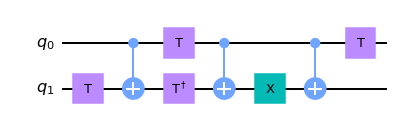

The unitary matrix for this subcircuit:
[[ 0.   +0.j     0.   +0.j     1.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.707+0.707j  0.   +0.j     0.   +0.j   ]
 [ 1.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   +0.j    -0.707+0.707j]]


In [10]:
print('A small piece of the decomposed Cuccaro adder:')
subcirc = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[2];\nt q[1];\ncx q[0],q[1];\nt q[0];\ntdg q[1];\ncx q[0],q[1];\nx q[1];\ncx q[0],q[1];\nt q[0];\n')
display(subcirc.draw(fold=-1))

# Calculate the unitary matrix for the subcircuit
u_subcirc = qiskit.quantum_info.Operator(subcirc).data
print('The unitary matrix for this subcircuit:')
print(u_subcirc.round(3))  # Round to simplify print output

In [11]:
# An object that can compute the KAK unitary matrix decomposition
# using the CNOT gate
# Source code: https://github.com/Qiskit/qiskit-terra/blob/6354f3f4fa7a294a0f8b0b54d6b5bc5cdae49eca/qiskit/quantum_info/synthesis/two_qubit_decompose.py#L635
kak = qiskit.quantum_info.synthesis.TwoQubitBasisDecomposer(
    qiskit.circuit.library.standard_gates.CXGate(), euler_basis='ZXZ')

# An object that represents the unitary in a cannonical form as three real numbers
# (ignoring single-qubit gates)
# These Weyl coordinates are (0.7853981633974483, 0.0, 0.0)
# The other matrices are extra single-qubit gates
weyl_coords = (qiskit.quantum_info.synthesis.two_qubit_decompose
               .TwoQubitWeylDecomposition(u_subcirc))
weyl_coords

TwoQubitWeylControlledEquiv.from_bytes(
    # TwoQubitWeylControlledEquiv(
    # 	global phase: 3π/2
    # 	     ┌──────────┐ ┌────────┐┌────────────┐┌──────────┐ ┌────────┐
    # 	q_0: ┤ Ry(-π/2) ├─┤ Rx(-π) ├┤0           ├┤ Ry(-π/2) ├─┤ Rx(-π) ├───────────
    # 	     ├──────────┤┌┴────────┤│  Rxx(-π/2) │├─────────┬┘┌┴────────┤┌─────────┐
    # 	q_1: ┤ Rx(-π/2) ├┤ Ry(π/4) ├┤1           ├┤ Rx(π/2) ├─┤ Ry(π/4) ├┤ Rx(π/2) ├
    # 	     └──────────┘└─────────┘└────────────┘└─────────┘ └─────────┘└─────────┘
    # )
    b'k05VTVBZAQB2AHsnZGVzY3InOiAnPGMxNicsICdmb3J0cmFuX29yZGVyJzogRmFsc2UsICdzaGFw'
    b'ZSc6ICg0LCA0KSwgfSAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg'
    b'ICAgICAgICAgICAgIAoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP7//////+8/AAAA'
    b'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMs7f2aeoOY/yzt/Zp6g5j8AAAAA'
    b'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPA/AAAAAAAAAAAAAAAAAAAAAAAAAAAA'
    b'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

In [12]:
print('Number of CNOT gates needed for this KAK decomposition:')
cnots_required = kak.num_basis_gates(u_subcirc)
cnots_required

Number of CNOT gates needed for this KAK decomposition:


1

In [13]:
# Only one CNOT is required so use `decomp1` to find the four
# single-qubit unitary matricies needed
u0l, u1l, u0r, u1r = kak.decomp1(weyl_coords)
print('Single qubit gates needed around the one CNOT gate:')
# Left on qubit 0, left on 1, right on 0, right on 1
u0l, u1l, u0r, u1r

Single qubit gates needed around the one CNOT gate:


(array([[ 6.12323400e-17+1.79380389e-16j,  1.21249965e-32+1.00000000e+00j],
        [-1.37237409e-32+1.00000000e+00j,  6.12323400e-17-1.99673462e-16j]]),
 array([[ 0.00061128-2.5320128e-04j, -0.38268335+9.2387933e-01j],
        [ 0.38268335+9.2387933e-01j,  0.00061128+2.5320128e-04j]]),
 array([[ 4.40144154e-17-1.38777878e-16j, -7.07106781e-01-7.07106781e-01j],
        [ 7.07106781e-01-7.07106781e-01j, -1.34015774e-16+7.85046229e-17j]]),
 array([[-0.00061128+2.5320128e-04j,  0.38268335+9.2387933e-01j],
        [-0.38268335+9.2387933e-01j, -0.00061128-2.5320128e-04j]]))

Optimal circuit if CNOT gates


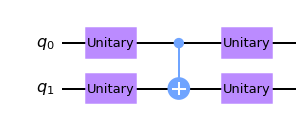

Circuits are equivalent!


In [14]:
# Make a circuit with these computed single-qubit unitaries
print('Optimal circuit if CNOT gates')
optimized_cnot = QuantumCircuit(2)
optimized_cnot.unitary(u0l, 0)
optimized_cnot.unitary(u1l, 1)
optimized_cnot.cx(0, 1)
optimized_cnot.unitary(u0r, 0)
optimized_cnot.unitary(u1r, 1)
display(optimized_cnot.draw(fold=-1))

# Check that it is correct
u_optimized_cnot = qiskit.quantum_info.Operator(optimized_cnot).data
assert matrix_equal(u_optimized_cnot, u_subcirc,
    ignore_phase=True, atol=1e-8, rtol=1e-8), (
    'Circuits are not equivalent')
print('Circuits are equivalent!')

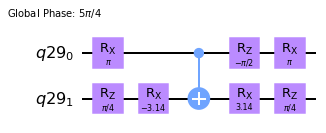

In [15]:
# Instead of all the above steps, ask Qiskit to do it automatically
optimized_cnot_auto = kak(u_subcirc)
optimized_cnot_auto.draw(fold=-1)

#### (1.2 continued)

For this problem, use KAK to compile `subcirc` for a device that only supports the **iSWAP** and single-qubit gates.

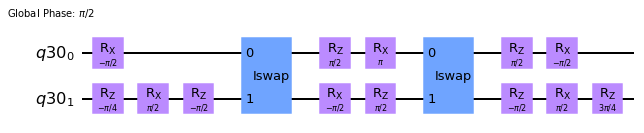

In [16]:
# Use Qiskit to compile `subcirc` using the fewest possible iSWAP gates
kak_iswap = qiskit.quantum_info.synthesis.TwoQubitBasisDecomposer(
    qiskit.circuit.library.iSwapGate(), euler_basis='ZXZ'
)

optimized_iswap = kak_iswap(u_subcirc)
optimized_iswap.draw(fold=-1)

# print('Your optimized circuit for an iSWAP-capable device:')
# optimized_iswap.draw(fold=-1)

In [17]:
# Do not delete this cell
# The autograder will test the value stored in `optimized_iswap`.
from collections import Counter
assert len(optimized_iswap.qasm().split('\ncx')) == 1, (
    'The solution should not contain any CNOT gates, only iSWAP (and single-qubit)')
assert len(optimized_iswap.qasm().split('\niswap')) <= 3, (
    'The optimal solution will contain two iSWAP gates')
u_optimized_iswap = qiskit.quantum_info.Operator(optimized_iswap).data
assert matrix_equal(u_optimized_iswap, u_subcirc,
    ignore_phase=True, atol=1e-8, rtol=1e-8), (
    'The compiled and original circuits are not equivalent')
# Hidden tests
print('PASS')

PASS


# 2. Global Optimization with the ZX Calculus

Recently, many powerful tools for circuit optimization have been developed that use a tool called the ZX Calculus.  After converting a quantum circuit into a ZX diagram it is easier to find simplifications, using the rules of the ZX calculus, that lead to smaller circuits.  You can [read more about ZX calculus here](https://zxcalculus.com/intro.html).

Follow the steps in the code below.

In [18]:
# Install pyzx on your computer
!pip install pyzx==0.6.4

In [19]:
!pip install ipywidgets

In [20]:
import pyzx as zx

# The cuccaro adder circuit
cuccaro = generate_adder_circuit(20)
cucc_decomp = qiskit.transpile(cuccaro, basis_gates=['x', 'h', 't', 'tdg', 'cx'])

# Convert the circuit into a ZX diagram
g = zx.Circuit.from_qasm(cuccaro.qasm())
#g = g.to_basic_gates().to_graph()
print('The ZX diagram of the decomposed cuccaro adder:')
display(zx.draw(g))

The ZX diagram of the decomposed cuccaro adder:


None

In [21]:
# Simplify the diagram by replacing yellow squares (Hadamards)
g = g.to_basic_gates().to_graph()
zx.draw(g)

## 2.1 Optimizer Routines

Now that we have a ZX diagram of the Cuccaro adder circuit, optimize the ZX diagram using one of the optimization routines listed here: [https://pyzx.readthedocs.io/en/latest/api.html](https://pyzx.readthedocs.io/en/latest/api.html#list-of-simplifications).  Find the one that optimizes this circuit the best.  I.e. the optimizer that results in a circuit with the fewest two-qubit gates.

In [22]:
# Reduce the circuit into a the form of a graph
# This will no longer look like a quantum circuit
# Additional work is needed to recover a valid quantum circuit
g_opt = zx.Graph.from_json(g.to_json())  # Convert to zx.Graph before optimizing

# YOUR CODE HERE
__________(g_opt)  # Try different optimizers here

zx.draw(g_opt)

Traceback (most recent call last):
  Input In [22] in <cell line: 7>
    __________(g_opt)  # Try different optimizers here
NameError: name '__________' is not defined

Use %tb to get the full traceback.


In [ ]:
# Convert the graph back into a quantum circuit
# This may not find the smallest possible circuit
c_opt = zx.extract_circuit(g_opt.copy(), quiet=True, optimize_cnots=3)
zx.draw(c_opt)

In [ ]:
# Do not delete this cell
# The autograder will test the value stored in `c_opt`.
_optimized = QuantumCircuit.from_qasm_str(c_opt.to_qasm())
assert len(cucc_decomp.qubits) == 20, 'The wrong input circuit was optimized.'
assert len(_optimized.qubits) == 20, 'Wrong number of qubits in the output circuit'
# Hidden tests

In [ ]:
# Convert this circuit back into a Qiskit circuit
optimized = QuantumCircuit.from_qasm_str(c_opt.to_qasm())
print(f'Optimized circuit:')
optimized.draw(fold=-1)

In [ ]:
print(f'Original circuit (for comparison):')
cucc_decomp.draw(fold=-1)

## 2.2 Output Circuit

Inspect the above "optimized" quantum circuit.  Does it look similar in structure to the original circuit with some gates removed or changed or is the structure completely different?

In [ ]:
answer = (  # 'similar' or 'different'
    # YOUR CODE HERE
)

In [ ]:
# Do not delete this cell
# The autograder will test the value stored in `c_opt`.
assert answer in ('similar', 'different'), 'Invalid answer'
# Hidden tests